<a href="https://colab.research.google.com/github/melvin97n/Housing_price_prediction/blob/master/housing_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
%matplotlib inline

In [0]:
import os
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"melvin97n","key":"e8805b38b4617ec29d832f8bbdfeaab8"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


total 4
-rw------- 1 root root 65 Aug  1 16:26 kaggle.json
{"username":"melvin97n","key":"e8805b38b4617ec29d832f8bbdfeaab8"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
df=pd.read_csv("train.csv")


In [0]:

df.tail(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.000,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.000,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.000,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.000,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.000,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.000,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.000,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.000,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.000,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,...,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.000,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.000,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,...,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.000,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [0]:
df.shape

(1460, 81)

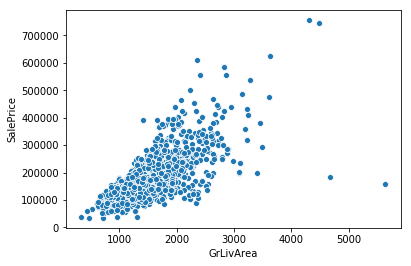

In [0]:
sns.scatterplot(df['GrLivArea'],df['SalePrice'])

In [0]:
df=df.drop('Id', axis=1)
df =df.drop(df[(df.SalePrice<300000) &(df.GrLivArea>4000)].index)
df.shape

(1458, 80)

In [0]:
y=df['SalePrice']

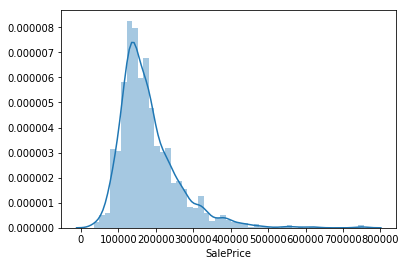

In [0]:
sns.distplot(y)

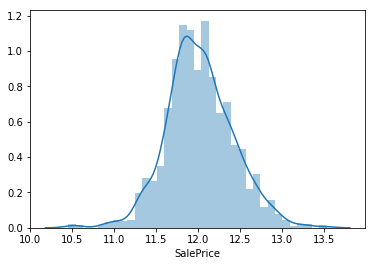

In [0]:
y=np.log1p(y)
sns.distplot(y)

In [0]:
x=df.drop('SalePrice',axis=1)
x.shape

(1458, 79)

In [0]:
df2=pd.read_csv('test.csv')
df2=df2.drop('Id',axis=1)
df2.shape

(1459, 79)

In [0]:
df2.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [0]:
all_data = pd.concat((df2,df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(2917, 79)

In [0]:
all_data.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2912,953,694,0,NaN,3,1Fam,TA,No,0.000,0.000,Unf,Unf,0.000,0.000,Gd,953.000,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,460.000,2.000,TA,RFn,TA,Attchd,1999.000,1647,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,7917,Inside,62.000,Reg,0,60,RL,0.000,None,NaN,0,8,Gilbert,40,5,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,953.000,AllPub,0,1999,2000,2007
2913,2073,0,0,NaN,3,1Fam,TA,No,790.000,163.000,ALQ,Rec,1.000,0.000,Gd,589.000,Y,Norm,Norm,SBrkr,0,TA,TA,Plywood,Plywood,MnPrv,TA,2,CBlock,2,Min1,500.000,2.000,TA,Unf,TA,Attchd,1978.000,2073,0,GasA,TA,1Story,1,TA,Lvl,Gtl,13175,Inside,85.000,Reg,0,20,RL,119.000,Stone,NaN,0,2,NWAmes,0,6,6,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,7,1542.000,AllPub,349,1978,1988,2010
2914,1188,1152,0,NaN,4,1Fam,Gd,No,275.000,0.000,GLQ,Unf,0.000,0.000,TA,877.000,Y,Norm,Norm,SBrkr,0,Gd,Ex,CemntBd,CmentBd,GdPrv,Gd,2,Stone,2,Typ,252.000,1.000,TA,RFn,TA,Attchd,1941.000,2340,0,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9042,Inside,66.000,Reg,0,70,RL,0.000,None,Shed,2500,5,Crawfor,60,9,7,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,9,1152.000,AllPub,0,1941,2006,2010
2915,1078,0,0,NaN,2,1Fam,TA,Mn,49.000,1029.000,GLQ,Rec,1.000,0.000,TA,0.000,Y,Norm,Norm,FuseA,112,TA,TA,MetalSd,MetalSd,NaN,NaN,0,CBlock,1,Typ,240.000,1.000,TA,Unf,TA,Attchd,1950.000,1078,0,GasA,Gd,1Story,1,Gd,Lvl,Gtl,9717,Inside,68.000,Reg,0,20,RL,0.000,None,NaN,0,4,NAmes,0,6,5,Y,0,NaN,CompShg,Hip,Normal,WD,0,Pave,5,1078.000,AllPub,366,1950,1996,2010
2916,1256,0,0,NaN,3,1Fam,TA,No,830.000,290.000,BLQ,LwQ,1.000,0.000,TA,136.000,Y,Norm,Norm,SBrkr,0,TA,Gd,HdBoard,HdBoard,NaN,NaN,0,CBlock,1,Typ,276.000,1.000,TA,Fin,TA,Attchd,1965.000,1256,1,GasA,Gd,1Story,1,TA,Lvl,Gtl,9937,Inside,75.000,Reg,0,20,RL,0.000,None,NaN,0,6,Edwards,68,6,5,Y,0,NaN,CompShg,Gable,Normal,WD,0,Pave,6,1256.000,AllPub,736,1965,1965,2008


In [0]:
miss=all_data.isnull().sum()
miss=miss.drop(miss[miss==0].index ).sort_values(ascending=False)
miss

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
dtype: int64

In [0]:
all_data['PoolQC']=all_data['PoolQC'].fillna("None")
all_data['MiscFeature']=all_data['MiscFeature'].fillna("None")
all_data['Alley']=all_data['Alley'].fillna("None")
all_data['Fence']=all_data['Fence'].fillna("None")
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [0]:
miss=all_data.isnull().sum()
miss=miss.drop(miss[miss==0].index ).sort_values(ascending=False)
miss

Series([], dtype: int64)

In [0]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
all_data.head()
  

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,896,0,0,1,2,1Fam,4,3,468.000,144.000,5,3,0.000,0.000,4,270.000,1,Feedr,Norm,SBrkr,0,4,3,VinylSd,VinylSd,2,3,0,CBlock,1,6,730.000,1.000,5,3,5,Attchd,1961.000,896,0,GasA,4,1Story,1,3,Lvl,0,11622,Inside,80.000,3,0,5,RH,0.000,None,None,0,8,NAmes,0,5,5,2,0,3,CompShg,Gable,Normal,WD,120,1,5,882.000,140,1961,1961,4
1,1329,0,0,1,3,1Fam,4,3,923.000,0.000,0,6,0.000,0.000,4,406.000,1,Norm,Norm,SBrkr,0,4,3,Wd Sdng,Wd Sdng,4,3,0,CBlock,1,6,312.000,1.000,5,3,5,Attchd,1958.000,1329,1,GasA,4,1Story,1,2,Lvl,0,14267,Corner,81.000,0,0,5,RL,108.000,BrkFace,Gar2,12500,8,NAmes,36,5,6,2,0,3,CompShg,Hip,Normal,WD,0,1,6,1329.000,393,1958,1958,4
2,928,701,0,1,3,1Fam,4,3,791.000,0.000,2,6,0.000,0.000,2,137.000,1,Norm,Norm,SBrkr,0,4,3,VinylSd,VinylSd,2,5,1,PConc,2,6,482.000,2.000,5,0,5,Attchd,1997.000,1629,1,GasA,2,2Story,1,3,Lvl,0,13830,Inside,74.000,0,0,10,RL,0.000,None,None,0,5,Gilbert,34,4,5,2,0,3,CompShg,Gable,Normal,WD,0,1,6,928.000,212,1997,1998,4
3,926,678,0,1,3,1Fam,4,3,602.000,0.000,2,6,0.000,0.000,4,324.000,1,Norm,Norm,SBrkr,0,4,3,VinylSd,VinylSd,4,2,1,PConc,2,6,470.000,2.000,5,0,5,Attchd,1998.000,1604,1,GasA,0,2Story,1,2,Lvl,0,9978,Inside,78.000,0,0,10,RL,20.000,BrkFace,None,0,8,Gilbert,36,5,6,2,0,3,CompShg,Gable,Normal,WD,0,1,7,926.000,360,1998,1998,4
4,1280,0,0,1,2,TwnhsE,4,3,263.000,0.000,0,6,0.000,0.000,2,1017.000,1,Norm,Norm,SBrkr,0,4,2,HdBoard,HdBoard,4,3,0,PConc,2,6,506.000,2.000,5,2,5,Attchd,1992.000,1280,0,GasA,0,1Story,1,2,HLS,0,5005,Inside,43.000,0,0,0,RL,0.000,None,None,0,0,StoneBr,82,4,8,2,0,3,CompShg,Gable,Normal,WD,144,1,5,1280.000,0,1992,1992,4


In [0]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 219)


In [0]:

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [0]:
train = all_data[:1458]
test = all_data[1458:]

In [0]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [0]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5).fit(train, y)

In [0]:
rmse_cv(model_lasso).mean()

0.39953648782602846

In [0]:
 preds=np.expm1(model_lasso.predict(test))

In [0]:
test=pd.read_csv('test.csv')

In [0]:
predictions = pd.DataFrame(columns=['Id', 'SalePrice'])
predictions['SalePrice']=preds
predictions['Id']=test['Id']

In [0]:
predictions.head()

,Id,SalePrice
0,1461,167157.102
1,1462,166981.965
2,1463,166794.363
3,1464,167088.965
4,1465,167147.704


In [0]:
predictions.shape

(1459, 2)

In [0]:
predictions.to_csv('predictions.csv') 